# Introduction
Section 2 of this project aims to use regression machine learning techniques to predict the prices of HDB resale flats in Tampines. In particular, we will be using linear regression, neural networks and regression trees/forests to attempt this. We will then compare the models using their root mean squared error (RMSE) scores. 

In [2]:
#Load packages and set default configurations

%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()

In [3]:
#Load the resale data set and slice out the relevant columns

df = pd.read_csv("resale_clean.csv")
resale = df.iloc[:, 1:12]
resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.33,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.58,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.08,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,265000.0


In [5]:
#Obtain summary information of the sliced dataset

resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60361 entries, 0 to 60360
Data columns (total 11 columns):
month                  60361 non-null object
town                   60361 non-null object
flat_type              60361 non-null object
block                  60361 non-null object
street_name            60361 non-null object
storey_range           60361 non-null object
floor_area_sqm         60361 non-null float64
flat_model             60361 non-null object
lease_commence_date    60361 non-null int64
remaining_lease        60361 non-null float64
resale_price           60361 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 5.1+ MB


In [6]:
#Filter out a subset of data with rows pertaining to 'Tampines'

resale_tamp = resale[resale['town'] == 'TAMPINES']
resale_tamp.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
910,2017-01,TAMPINES,2 ROOM,299A,TAMPINES ST 22,01 TO 03,45.0,Model A,2012,94.17,250000.0
911,2017-01,TAMPINES,3 ROOM,403,TAMPINES ST 41,01 TO 03,60.0,Improved,1985,67.75,270000.0
912,2017-01,TAMPINES,3 ROOM,802,TAMPINES AVE 4,04 TO 06,68.0,New Generation,1984,66.42,295000.0
913,2017-01,TAMPINES,3 ROOM,410,TAMPINES ST 41,01 TO 03,69.0,Improved,1985,67.67,300000.0
914,2017-01,TAMPINES,3 ROOM,462,TAMPINES ST 44,07 TO 09,64.0,Simplified,1987,69.50,305000.0


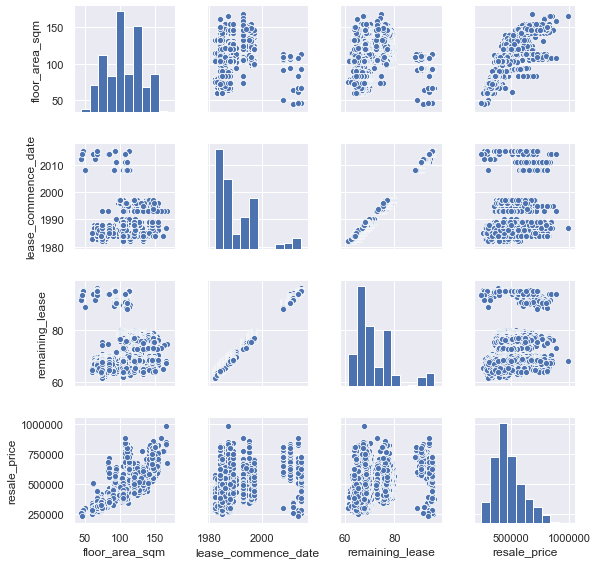

In [7]:
#Visually plot the relevant variables against each other 

sns.pairplot(resale_tamp, height = 2)

In [10]:
#Obtain the feature matrix for the machine learning algorithms

c = ['storey_range', 'floor_area_sqm', 'remaining_lease', 'resale_price']
tamp = resale_tamp.loc[:, c]
tamp.head()

,storey_range,floor_area_sqm,remaining_lease,resale_price
910,01 TO 03,45.0,94.17,250000.0
911,01 TO 03,60.0,67.75,270000.0
912,04 TO 06,68.0,66.42,295000.0
913,01 TO 03,69.0,67.67,300000.0
914,07 TO 09,64.0,69.50,305000.0


In [11]:
#Perform one-hot encoding of 'storey_range' to create dummy variables for each category
#This format will then be suitable to be fed into the machine learning algorithm 

tamp_onehot = pd.get_dummies(tamp['storey_range'])
ml_tamp = tamp.join(tamp_onehot)
del ml_tamp['storey_range']
ml_tamp.head()

,floor_area_sqm,remaining_lease,resale_price,01 TO 03,04 TO 06,07 TO 09,10 TO 12,13 TO 15,16 TO 18
910,45.0,94.17,250000.0,1,0,0,0,0,0
911,60.0,67.75,270000.0,1,0,0,0,0,0
912,68.0,66.42,295000.0,0,1,0,0,0,0
913,69.0,67.67,300000.0,1,0,0,0,0,0
914,64.0,69.50,305000.0,0,0,1,0,0,0


In [15]:
#Generate a table reflecting the correlation score between each variable in the data set 

corr = ml_tamp.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,floor_area_sqm,remaining_lease,resale_price,01 TO 03,04 TO 06,07 TO 09,10 TO 12,13 TO 15,16 TO 18
floor_area_sqm,1,0.0642802,0.818379,-0.0239364,0.015982,0.00910174,0.00126659,-0.00719309,-0.00157707
remaining_lease,0.0642802,1,0.319862,-0.0832341,-0.0748963,0.0116876,0.0296836,0.23727,0.135697
resale_price,0.818379,0.319862,1,-0.148889,-0.0148035,0.0335948,0.0776728,0.104759,0.0926761
01 TO 03,-0.0239364,-0.0832341,-0.148889,1,-0.362359,-0.314869,-0.269589,-0.107426,-0.0387638
04 TO 06,0.015982,-0.0748963,-0.0148035,-0.362359,1,-0.361574,-0.309577,-0.123361,-0.0445136
07 TO 09,0.00910174,0.0116876,0.0335948,-0.314869,-0.361574,1,-0.269005,-0.107194,-0.0386798
10 TO 12,0.00126659,0.0296836,0.0776728,-0.269589,-0.309577,-0.269005,1,-0.0917785,-0.0331174
13 TO 15,-0.00719309,0.23727,0.104759,-0.107426,-0.123361,-0.107194,-0.0917785,1,-0.0131967
16 TO 18,-0.00157707,0.135697,0.0926761,-0.0387638,-0.0445136,-0.0386798,-0.0331174,-0.0131967,1


It seems that resale_price is rather correlated to floor_area_sqm ($p$ = 0.818) and remaining_lease ($p$ = 0.320). 

In [16]:
#Create both training (features) and test (outcomes) set data 

X_tamp = ml_tamp.loc[:, ml_tamp.columns != 'resale_price']
y_tamp = ml_tamp['resale_price']

In [17]:
#Create a 70-30 train test split, and set a seed to ensure they are constant
#Allows for the model to train and be evaluated on the same set of data 

from sklearn.model_selection import train_test_split

X1, X2, y1, y2 = train_test_split(X_tamp, y_tamp, random_state=42, train_size=0.7)

## Model 1. Linear Regression Model

In [25]:
from sklearn.linear_model import LinearRegression 
lin_model = LinearRegression(fit_intercept=True)

lin_model.fit(X1, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
y_predict = lin_model.predict(X2)

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y2,y_predict))
print(round(rms, 2))

60634.94


In [14]:
ml_tamp.to_csv('ml_tamp.csv')

## Purely for fun: Neural Networks

In [28]:
import numpy as np 
from keras.layers import Dense
from keras.models import Sequential
from keras import metrics

predictors = X1
n_cols = predictors.shape[1]
nn_model= Sequential()
nn_model.add(Dense(1000, activation='relu',input_shape=(n_cols,)))
nn_model.add(Dense(750, activation='relu'))
nn_model.add(Dense(500, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(optimizer='adam', 
              loss= 'mean_squared_error',
              metrics=['mae'])

Using TensorFlow backend.


In [29]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
callbacks = [EarlyStopping(monitor='loss', patience=2), ModelCheckpoint(filepath='best_model.h5', monitor='loss')]

nn_model.fit(predictors,y1,epochs=100, callbacks=callbacks)

Epoch 1/100
2658/2658 [==============================] - 1s 531us/step - loss: 128777639511.8375 - mae: 300757.3438
Epoch 2/100
2658/2658 [==============================] - 1s 501us/step - loss: 5366987195.1362 - mae: 54262.6641
Epoch 3/100
2658/2658 [==============================] - 1s 499us/step - loss: 5037169623.0910 - mae: 52968.3125
Epoch 4/100
2658/2658 [==============================] - 1s 493us/step - loss: 4934564909.4597 - mae: 52043.4922
Epoch 5/100
2658/2658 [==============================] - 1s 497us/step - loss: 4794762137.5230 - mae: 51027.1406
Epoch 6/100
2658/2658 [==============================] - 1s 484us/step - loss: 4703677272.0301 - mae: 49859.6523
Epoch 7/100
2658/2658 [==============================] - 1s 478us/step - loss: 4635194316.9541 - mae: 48806.6719
Epoch 8/100
2658/2658 [==============================] - 1s 507us/step - loss: 4631930630.7419 - mae: 48379.3984
Epoch 9/100
2658/2658 [==============================] - 2s 599us/step - loss: 4570140405.020

In [30]:
from keras.models import load_model
final_model = load_model('best_model.h5')

In [31]:
y_predict = final_model.predict(X2)

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y2,y_predict))
rms

65563.05816738935

## Purely for fun: CART
Need to refer to Datacamp notes and resources to do a more rigorous analysis and coding. 

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

dt = DecisionTreeRegressor(max_depth=4,
                          min_samples_leaf=0.01,
                          random_state=3)

In [34]:
dt.fit(X1,y1)
y_predict = dt.predict(X2)


In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y2,y_predict))
rms

42274.18557615453